In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("C:/Users/oekpom/Desktop/Datasets/Machine Learning/Lesson 8/AirPassengers.csv")

In [3]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
data["Month"] = data["Month"].apply(lambda x: dt(int(x[:4]), int(x[5:]),15))
data = data.set_index("Month")
data.head()

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


In [6]:
ts = data["#Passengers"]

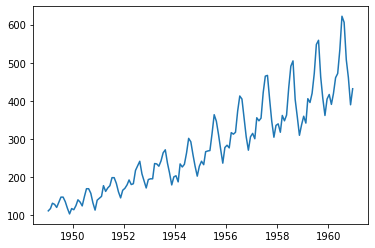

In [7]:
plt.plot(ts)

In [8]:
ts_log = np.log(ts)

In [9]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=52, center=False).mean()
    rolstd = timeseries.rolling(window=52, center=False).std()
    
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling std")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Standard deviation")
    plt.show(block=False)
    
    print("Results of Dickey-Fuller test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" %key] = value
    print(dfoutput)

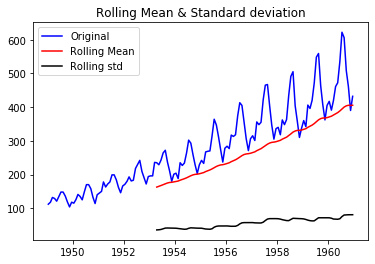

Results of Dickey-Fuller test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [10]:
test_stationarity(data["#Passengers"])

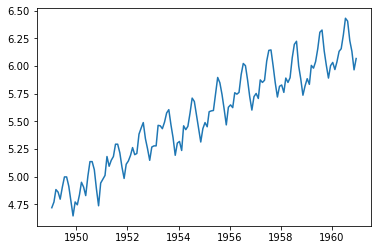

In [11]:
plt.plot(ts_log)

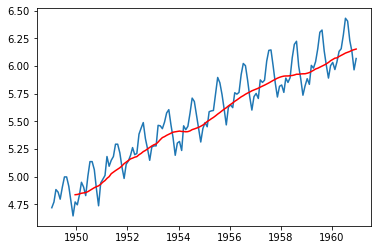

In [12]:
movingAverage = ts_log.rolling(window=12).mean()
movingSTD = ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(movingAverage, color="red")

In [13]:
ts_log_mv_diff = ts_log - movingAverage
ts_log_mv_diff.head(12)

ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(10)

Month
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
1950-04-15    0.052142
1950-05-15   -0.027529
1950-06-15    0.139881
1950-07-15    0.260184
1950-08-15    0.248635
1950-09-15    0.162937
Name: #Passengers, dtype: float64

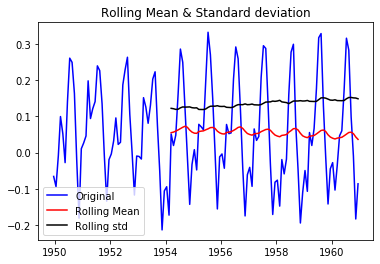

Results of Dickey-Fuller test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [14]:
test_stationarity(ts_log_mv_diff)

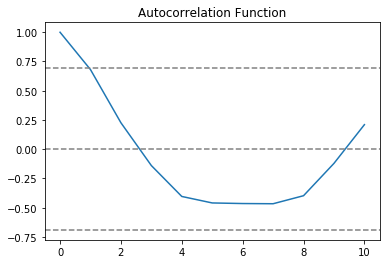

In [15]:
plt.plot(np.arange(0,11),acf(ts_log_mv_diff, nlags=10))
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)), linestyle="--", color="gray")
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)), linestyle="--", color="gray")
plt.title("Autocorrelation Function")
plt.show()

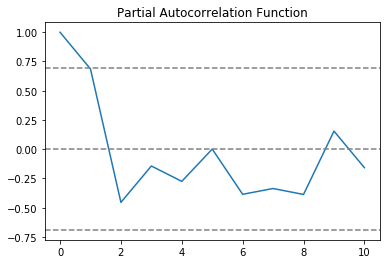

In [16]:
plt.plot(np.arange(0,11),pacf(ts_log_mv_diff, nlags=10))
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)), linestyle="--", color="gray")
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)), linestyle="--", color="gray")
plt.title("Partial Autocorrelation Function")
plt.show()

Text(0.5, 1.0, 'RSS: nan')

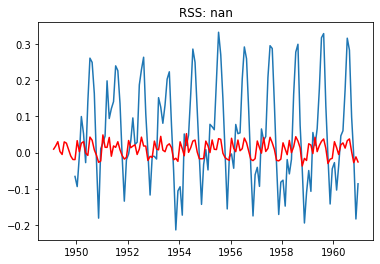

In [17]:
model = ARIMA(ts_log, order=(1,1,0))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues, color="red")
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues[1:] - ts_log_mv_diff)**2))

In [18]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-15    0.009676
1949-03-15    0.018164
1949-04-15    0.030130
1949-05-15    0.003154
1949-06-15   -0.005039
dtype: float64

In [19]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-15    0.009676
1949-03-15    0.027839
1949-04-15    0.057969
1949-05-15    0.061123
1949-06-15    0.056084
dtype: float64

In [20]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-15    4.718499
1949-02-15    4.728175
1949-03-15    4.746338
1949-04-15    4.776468
1949-05-15    4.779622
dtype: float64

Text(0.5, 1.0, 'RMSE: 52.1841')

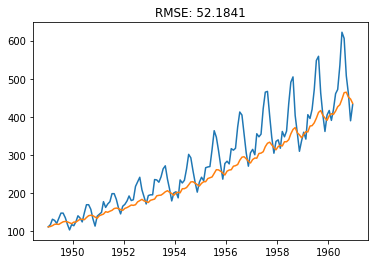

In [21]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'%np.sqrt(sum((predictions_ARIMA - ts)**2)/len(ts)))